# Using deterministic probability assignment

In [3]:
import torch

N = torch.zeros(27, 27, dtype=torch.int32)

In [39]:
# Reading words
words = [word for line in open('names.txt', 'r') for word in line.split()]

In [9]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {s:i for i,s in stoi.items()}

In [63]:
for w in words[0:1]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        N[stoi[ch1], stoi[ch2]] += 1

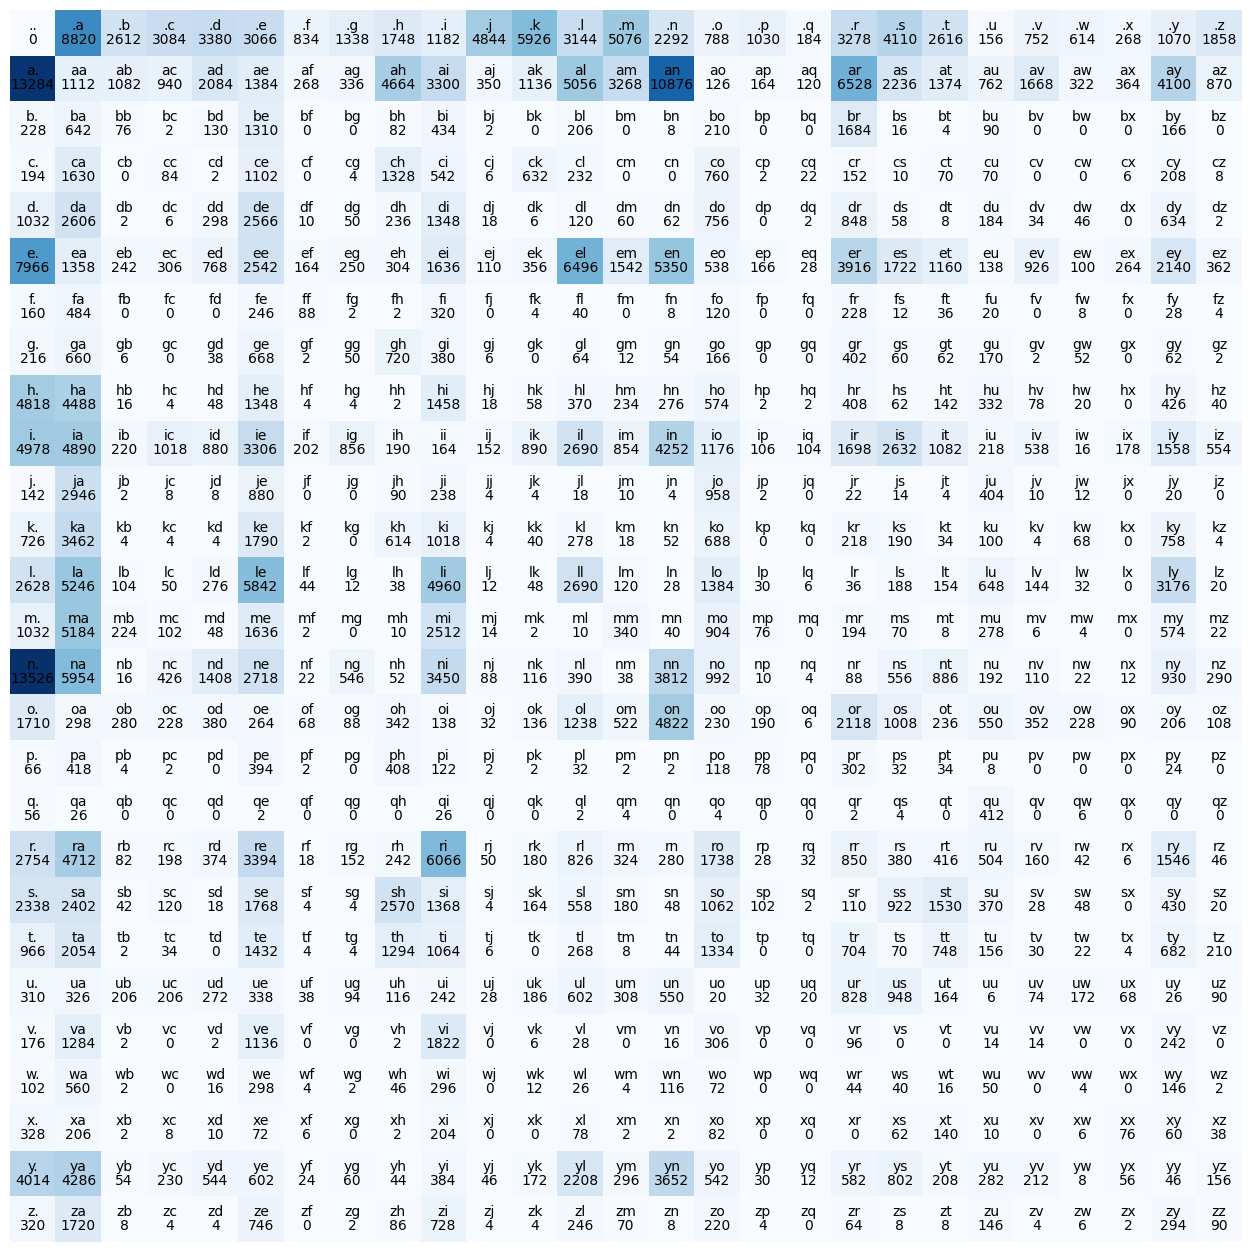

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="black")
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color="black")
        plt.axis('off')

In [73]:
N.sum(1,keepdim=True).size()

torch.Size([27, 1])

In [76]:
# Defining P matrix
P = (N+1).float() # +1 for model smoothing 
# 27x27 dim divided by 27x1 dim --> broadcasting
P = P/P.sum(1, keepdim=True)

In [305]:
# Sampling
g = torch.Generator().manual_seed(2147483647)
for i in range(30):
    word = ''
    ix = 0
    while(True):
        p = P[ix]
        jx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        word += itos[jx]
        if(jx==0):
            break
        ix = jx
    print(word)

cexze.
momasurailezitynn.
konimittain.
llayn.
ka.
da.
staiyaubrtthrigotai.
moliellavo.
ke.
teda.
ka.
emimmsade.
enkaviyny.
ftlspihinivenvorhlasu.
dsor.
br.
jol.
pen.
aisan.
ja.
feniee.
zem.
deru.
firit.
gaikajahahbevare.
kiysthelenaririenah.
keen.
x.
al.
kalmahavazeeromysos.


In [177]:
# Loss function
log_likelihood = 0.0
n=0
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        prob = P[stoi[ch1], stoi[ch2]]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        N[stoi[ch1], stoi[ch2]] += 1
        #print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')
loss = -log_likelihood/n

# Using neural nets

In [86]:
# Creating dataset
xs, ys = [],[]
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        xs.append(stoi[ch1])
        ys.append(stoi[ch2])
xs = torch.tensor(xs)
ys = torch.tensor(ys)

num = xs.nelement()
print("Number of examples", num)

Number of examples 228146


In [87]:
# Weight initialization
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [108]:
# Gradient descent 
import torch.nn.functional as F

for iter in range(1):
    # Forward pass
    
    xenc = F.one_hot(xs, num_classes=27).float()
    logits = xenc@W
    # Applying softmax 
    probs = F.softmax(logits, dim=1)
    print(probs[1])
    loss = -probs[torch.arange(num), ys].log().mean()
    print(loss.item())
    
    # Backward pass 
    W.grad = None
    loss.backward()

    # Weight updation
    W.data += -50 * W.grad


tensor([0.1950, 0.0332, 0.0059, 0.0075, 0.0188, 0.0622, 0.0040, 0.0061, 0.0074,
        0.0400, 0.0027, 0.0087, 0.1590, 0.0376, 0.1310, 0.0132, 0.0041, 0.0009,
        0.0959, 0.0421, 0.0284, 0.0034, 0.0227, 0.0024, 0.0065, 0.0524, 0.0089],
       grad_fn=<SelectBackward0>)
2.4590606689453125


In [306]:
# Sampling from neural net
g = torch.Generator().manual_seed(2147483647)

for i in range(30):
    word = ''
    ix = 0
    while(True):
        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = xenc@W
        probs = F.softmax(logits, dim=1)
        jx = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        word += itos[jx]
        if(jx==0):
            break
        ix = jx
        
    print(word)

cexze.
momasurailezitynn.
konimittain.
llayn.
ka.
da.
staiyaubrtthrigotai.
moliellavo.
ke.
teda.
ka.
emimmsade.
eniaviyny.
fobspehinivenvtahlasu.
dsor.
br.
jol.
pen.
aisan.
ja.
feniee.
zem.
deru.
firit.
gaikajahahbevare.
kiysthelenaririenah.
keen.
x.
al.
kal.
